In [1]:
import pandas as pd
import numpy as np
from datetime import date
import os
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# %env JOBLIB_TEMP_FOLDER=/tmp
%matplotlib inline

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger_output = logging.FileHandler('o2o-v2-gbdt.log', mode='a')
logger_output.setLevel(logging.DEBUG)
formatter = logging.Formatter("[%(asctime)s]: %(message)s")
logger_output.setFormatter(formatter)
logger.addHandler(logger_output)

In [18]:
def get_model_input(model='gbdt', set_param=False, train=False, pred=False):
    dataset1 = pd.read_csv('../input/dataset1.csv')
    dataset2 = pd.read_csv('../input/dataset2.csv')
    dataset3 = pd.read_csv('../input/dataset3.csv')
    Submission = pd.read_csv('../input/Submission.csv')
    print('...read dataset complete...')

    if model != 'xgb':
        # 如果模型不是xgb填充-999
        dataset1.fillna(-999, inplace=True)
        dataset2.fillna(-999, inplace=True)
        dataset3.fillna(-999, inplace=True)
    dataset = pd.concat([dataset1, dataset2], axis=0)
    if set_param:
        Y_train = dataset1[['label']]
        X_train = dataset1.drop(columns='label')
        return X_train, Y_train
    if train:
        split_point = len(dataset) * 4 // 5
        train_data = dataset.iloc[: split_point, :]
        test_data = dataset.iloc[split_point:, :]
        Y_train = train_data[['label']]
        X_train = train_data.drop(columns='label')
        Y_test = test_data[['label']]
        X_test = test_data.drop(columns='label')
        print(dataset.shape, train_data.shape, test_data.shape)
        return X_train, Y_train, X_test, Y_test
    if pred:
        Y_train = dataset[['label']]
        X_train = dataset.drop(columns='label')
        X_pred = dataset3
        return X_train, Y_train, X_pred, Submission

    
def get_model(model='gbdt', search=False):
    estimator = GradientBoostingClassifier(
        random_state=621,
        verbose=1,
        learning_rate=0.1,
        n_estimators=80,
        subsample=0.8,
        max_features='sqrt',
        min_samples_leaf=60,
        min_samples_split=210,
        max_depth=12
    )
    param_grid = {
        # 'n_estimators': [i for i in range(50, 81, 10)]
        # 'n_estimators': [2, 3]
        #'subsample': [.7, .75, .8, .85, .9]
        # 'max_features': [i for i in range(9, 14)]
        # 'min_samples_leaf': [i for i in range(1, 91, 10)]
        # 'min_samples_leaf': [i for i in range(81, 162, 10)]
        # 'min_samples_split': [i for i in range(22, 103, 10)]
        # 'max_depth': [i for i in range(5, 11)]
        # 'max_depth': [11, 12, 13]
        # 'min_samples_split': [220, 230],
        # 'min_samples_leaf': [70, 80]
        # 'max_features': [10, 11, 12]
    }
    # Grid Search
    if search:
        X_train, Y_train = get_model_input(model, set_param=True)
        grid = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=48,
            cv=5)
        grid.fit(X_train, Y_train)
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        logging.info('Model: %s' % model)
        logging.info('means: %s' % means)
        logging.info('stds: %s' % stds)
        logging.info('scores: %s' % grid.grid_scores_)
        logging.info('best params: %s' % grid.best_params_)
        logging.info('best scores: %s' % grid.best_score_)
        logging.info('--------------------------------------------------------')

        plt.figure(figsize=(16, 4))
        if len(param_grid.keys()) == 1:
            xdata = list(param_grid.values())[0]
        else:
            xdata = [i for i in range(1, len(means) + 1)]
        plt.subplot(1, 2, 1)
        plt.title('Mean AUC on Validation')
        plt.plot(xdata, means)
        plt.ylabel('Mean AUC')
        plt.subplot(1, 2, 2)
        plt.title('Std AUC on Validation')
        plt.plot(xdata, stds)
        plt.ylabel('Std AUC')
        plt.show()
    return estimator


def training(model='gbdt'):
    X_train, Y_train, X_test, Y_test = get_model_input(model, train=True)
    estimator = get_model(model='gbdt')
    estimator.fit(X_train, Y_train)
    Y_pred = estimator.predict(X_test)
    Y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    logging.info('Estimator: %s' % model)
    param = estimator.get_params()
    logging.info('parameters: learning_rate=%.3f, n_estimators=%d, max_depth=%d, min_samples_split=%d, min_samples_leaf=%d, max_features=%d, subsamples=%.2f' % (param['learning_rate'], param['n_estimators'], param['max_depth'], param['min_samples_split'], param['min_samples_leaf'], param['max_features'], param['subsample']))
    logging.info('Accuracy: %f' % metrics.accuracy_score(Y_test, Y_pred))
    logging.info('AUC: %f' % metrics.roc_auc_score(Y_test, Y_pred_prob))
    
    
def prediction(model='gbdt'):
    X_train, Y_train, X_pred, Submission = get_model_input(model=model, pred=True)
    estimator = get_model(model='gbdt')
    estimator.fit(X_train, Y_train)
    Y_pred_prob = estimator.predict_proba(X_pred)[:, 1]
    Submission['Proba'] = Y_pred_prob
    Submission.to_csv(model + '_preds.csv', index=False, header=False)
    
    logging.info('Estimator: %s' % model)
    param = estimator.get_params()
    logging.info('parameters: learning_rate=%.3f, n_estimators=%d, max_depth=%d, min_samples_split=%d, min_samples_leaf=%d, max_features=%s, subsamples=%.2f' % (param['learning_rate'], param['n_estimators'], param['max_depth'], param['min_samples_split'], param['min_samples_leaf'], param['max_features'], param['subsample']))

    featureImportance = pd.Series(estimator.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    featureImportance.to_csv(model + '_featureImportance.csv')
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    featureImportance[1: 20].plot(kind='bar', title='Top 20 Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Feature Importance Score')
    plt.subplot(2, 1, 2)
    featureImportance[-20: ].plot(kind='bar', title='Last 20 Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Feature Importance Score')
    plt.show()

...read dataset complete...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5951           0.0519            7.98m
         2           0.5613           0.0323            8.28m
         3           0.5337           0.0253            8.30m
         4           0.5156           0.0182            7.95m
         5           0.4979           0.0157            8.03m
         6           0.4851           0.0128            7.99m
         7           0.4730           0.0112            7.88m
         8           0.4641           0.0092            7.69m
         9           0.4546           0.0079            7.54m
        10           0.4459           0.0070            7.32m
        20           0.4027           0.0020            6.18m
        30           0.3839           0.0006            4.82m
        40           0.3727           0.0002            3.53m
        50           0.3663           0.0002            2.49m
        60           0.3589           0.0

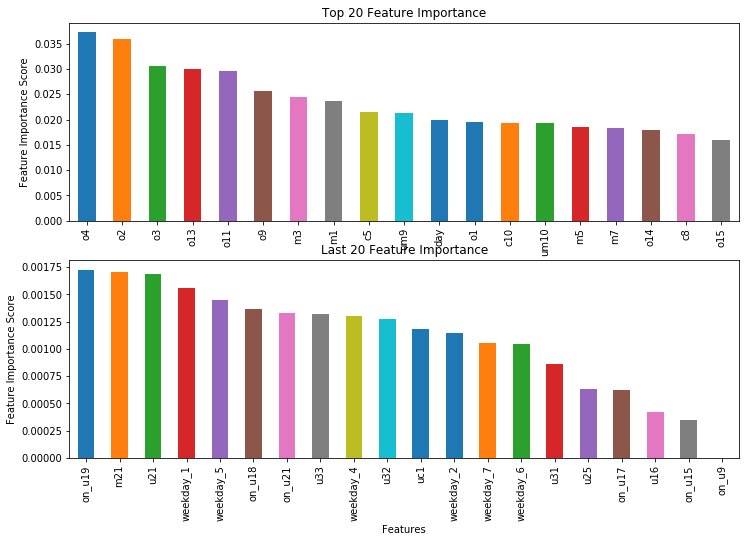

In [19]:
# gbdt = get_model(model='gbdt', search=True)
# training(model='gbdt')
prediction(model='gbdt')